In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
!ls /content/drive/MyDrive/MusicProject/Processed


label_map.json	X.npy  y.npy


In [ ]:
import numpy as np

X = np.load('/content/drive/MyDrive/MusicProject/Processed/X.npy')
y = np.load('/content/drive/MyDrive/MusicProject/Processed/y.npy')

print(X.shape)
print(y.shape)


(5600, 128, 128)
(5600,)


In [ ]:
# Right now, X looks like this:
# (number_of_samples, height, width)
# Example: (5600, 128, 128)

# CNNs don't like "flat images".
# They expect a channel dimension, just like:
# - RGB images → 3 channels
# - Grayscale images → 1 channel

# Our spectrograms are grayscale,
# so we manually add a "1" channel at the end.

X = X.reshape(X.shape[0], X.shape[1], X.shape[2], 1)

# Always print shape after reshaping.
# This is a sanity check to make sure nothing broke.
print("New X shape:", X.shape)


New X shape: (5600, 128, 128, 1)


In [ ]:
# Right now, y contains labels like:
# "Guitar", "Flute", "Bass", etc.

# Neural networks DO NOT understand text.
# They only understand numbers.

# LabelEncoder converts each instrument name
# into a unique integer.
# Example:
# Guitar → 3
# Flute  → 1
# Bass   → 0

from sklearn.preprocessing import LabelEncoder

encoder = LabelEncoder()

# Fit = learn all unique labels
# Transform = convert labels to numbers
y_encoded = encoder.fit_transform(y)

# Print the mapping so we KNOW what number means what
print("Instrument classes (label order):")
print(encoder.classes_)

print("Encoded labels shape:", y_encoded.shape)


Instrument classes (label order):
[0 1 2 3 4 5 6 7]
Encoded labels shape: (5600,)


In [ ]:
# If we train and test on the same data,
# the model might just MEMORIZE instead of LEARN.

# So we hide 20% of the data from the model.
# This hidden data is called the validation set.

from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(
    X,
    y_encoded,
    test_size=0.2,      # 20% for validation
    random_state=42,    # makes results reproducible
    stratify=y_encoded  # keeps class balance intact
)

# Print shapes to verify split worked correctly
print("Training data shape:", X_train.shape, y_train.shape)
print("Validation data shape:", X_val.shape, y_val.shape)


Training data shape: (4480, 128, 128, 1) (4480,)
Validation data shape: (1120, 128, 128, 1) (1120,)


In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, Dropout

# CNN v3 — deeper model to increase accuracy
model = Sequential()

model.add(Input(shape=(128, 128, 1)))

# Conv block 1
model.add(Conv2D(32, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))

# Conv block 2
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))

# Conv block 3 (NEW — this is the upgrade)
model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))

model.add(Flatten())

model.add(Dense(256, activation='relu'))
model.add(Dropout(0.5))

model.add(Dense(len(set(y_encoded)), activation='softmax'))

model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

model.summary()


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 126, 126, 32)   │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 63, 63, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 61, 61, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 30, 30, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 28, 28, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 14, 14, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │     6,422,784 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 8)              │         2,056 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6,517,512 (24.86 MB)

 Trainable params: 6,517,512 (24.86 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
import numpy as np

print("Unique labels:", np.unique(y_encoded))
print("Label counts:", np.bincount(y_encoded))


Unique labels: [0 1 2 3 4 5 6 7]
Label counts: [700 700 700 700 700 700 700 700]


In [ ]:
print("X dtype:", X.dtype)
print("X min:", X.min())
print("X max:", X.max())


X dtype: float32
X min: -80.0
X max: 0.0


In [ ]:
# Normalize log-mel spectrograms from [-80, 0] → [0, 1]
X = (X + 80.0) / 80.0

print("After normalization:")
print("X min:", X.min())
print("X max:", X.max())


After normalization:
X min: 0.0
X max: 1.0


In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(
    X,
    y_encoded,
    test_size=0.2,
    random_state=42,
    stratify=y_encoded
)

print(X_train.shape, y_train.shape)
print(X_val.shape, y_val.shape)



(4480, 128, 128, 1) (4480,)
(1120, 128, 128, 1) (1120,)


In [ ]:
model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)


In [ ]:
history_test = model.fit(
    X_train, y_train,
    epochs=5,
    batch_size=32,
    validation_data=(X_val, y_val),
    verbose=1
)


Epoch 1/5
140/140 ━━━━━━━━━━━━━━━━━━━━ 3s 20ms/step - accuracy: 0.9855 - loss: 0.0465 - val_accuracy: 0.9089 - val_loss: 0.4178
Epoch 2/5
140/140 ━━━━━━━━━━━━━━━━━━━━ 3s 19ms/step - accuracy: 0.9898 - loss: 0.0326 - val_accuracy: 0.9062 - val_loss: 0.4618
Epoch 3/5
140/140 ━━━━━━━━━━━━━━━━━━━━ 3s 20ms/step - accuracy: 0.9924 - loss: 0.0245 - val_accuracy: 0.9125 - val_loss: 0.4373
Epoch 4/5
140/140 ━━━━━━━━━━━━━━━━━━━━ 3s 19ms/step - accuracy: 0.9897 - loss: 0.0385 - val_accuracy: 0.9134 - val_loss: 0.4760
Epoch 5/5
140/140 ━━━━━━━━━━━━━━━━━━━━ 3s 19ms/step - accuracy: 0.9874 - loss: 0.0446 - val_accuracy: 0.9143 - val_loss: 0.4514


In [ ]:
history_v3 = model.fit(
    X_train, y_train,
    epochs=20,
    batch_size=32,
    validation_data=(X_val, y_val),
    verbose=1
)


Epoch 1/20
140/140 ━━━━━━━━━━━━━━━━━━━━ 4s 31ms/step - accuracy: 0.9932 - loss: 0.0189 - val_accuracy: 0.9143 - val_loss: 0.4257
Epoch 2/20
140/140 ━━━━━━━━━━━━━━━━━━━━ 3s 19ms/step - accuracy: 0.9847 - loss: 0.0395 - val_accuracy: 0.9161 - val_loss: 0.4267
Epoch 3/20
140/140 ━━━━━━━━━━━━━━━━━━━━ 3s 19ms/step - accuracy: 0.9790 - loss: 0.0541 - val_accuracy: 0.9250 - val_loss: 0.3653
Epoch 4/20
140/140 ━━━━━━━━━━━━━━━━━━━━ 3s 19ms/step - accuracy: 0.9845 - loss: 0.0440 - val_accuracy: 0.9062 - val_loss: 0.4925
Epoch 5/20
140/140 ━━━━━━━━━━━━━━━━━━━━ 5s 19ms/step - accuracy: 0.9875 - loss: 0.0359 - val_accuracy: 0.9071 - val_loss: 0.4278
Epoch 6/20
140/140 ━━━━━━━━━━━━━━━━━━━━ 3s 19ms/step - accuracy: 0.9920 - loss: 0.0239 - val_accuracy: 0.9089 - val_loss: 0.5068
Epoch 7/20
140/140 ━━━━━━━━━━━━━━━━━━━━ 3s 19ms/step - accuracy: 0.9899 - loss: 0.0354 - val_accuracy: 0.9098 - val_loss: 0.4344
Epoch 8/20
140/140 ━━━━━━━━━━━━━━━━━━━━ 3s 19ms/step - accuracy: 0.9951 - loss: 0.0189 - val_accu

In [ ]:
model.save("instrunet_model_v3.keras")


In [ ]:
!mv instrunet_model_v3.keras /content/drive/MyDrive/MusicProject/

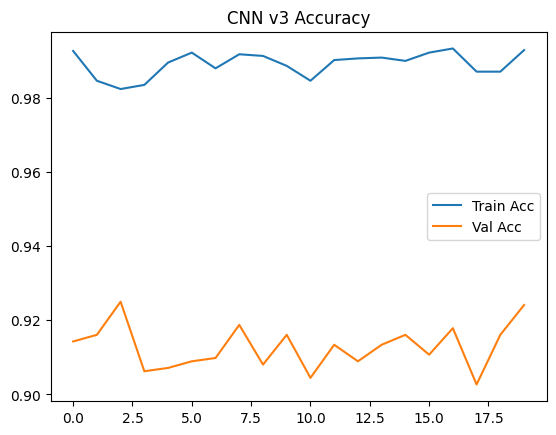

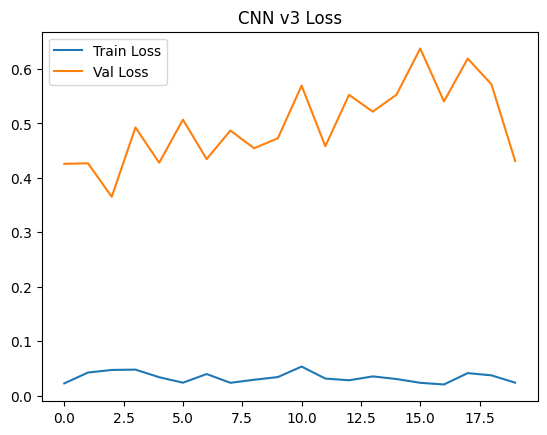

In [ ]:
import matplotlib.pyplot as plt

plt.figure()
plt.plot(history_v3.history['accuracy'], label='Train Acc')
plt.plot(history_v3.history['val_accuracy'], label='Val Acc')
plt.legend()
plt.title("CNN v3 Accuracy")
plt.show()

plt.figure()
plt.plot(history_v3.history['loss'], label='Train Loss')
plt.plot(history_v3.history['val_loss'], label='Val Loss')
plt.legend()
plt.title("CNN v3 Loss")
plt.show()


35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step


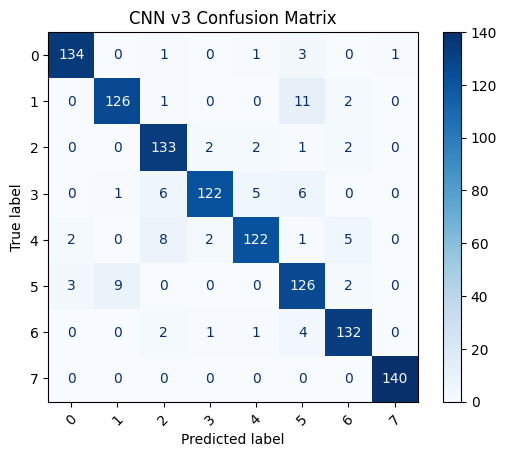

In [ ]:
import numpy as np
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

y_pred = model.predict(X_val)
y_pred_cls = np.argmax(y_pred, axis=1)

cm = confusion_matrix(y_val, y_pred_cls)

disp = ConfusionMatrixDisplay(cm, display_labels=encoder.classes_)
disp.plot(cmap="Blues", xticks_rotation=45)
plt.title("CNN v3 Confusion Matrix")
plt.show()


In [ ]:
import numpy as np

# Predict class probabilities
y_pred_probs = model.predict(X_val)

# Convert probabilities to class indices
y_pred = np.argmax(y_pred_probs, axis=1)


35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step


In [32]:
from sklearn.metrics import classification_report
import numpy as np

# Explicit class names in the correct order
instrument_names = [
    "brass",
    "flute",
    "guitar",
    "keyboard",
    "mallet",
    "reed",
    "string",
    "vocal"
]

# Generate predictions (if not already done)
y_pred_probs = model.predict(X_val)
y_pred = np.argmax(y_pred_probs, axis=1)

# Classification report with correct class names
report = classification_report(
    y_val,
    y_pred,
    target_names=instrument_names
)

print(report)


35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
              precision    recall  f1-score   support

       brass       0.96      0.96      0.96       140
       flute       0.93      0.90      0.91       140
      guitar       0.88      0.95      0.91       140
    keyboard       0.96      0.87      0.91       140
      mallet       0.93      0.87      0.90       140
        reed       0.83      0.90      0.86       140
      string       0.92      0.94      0.93       140
       vocal       0.99      1.00      1.00       140

    accuracy                           0.92      1120
   macro avg       0.93      0.92      0.92      1120
weighted avg       0.93      0.92      0.92      1120



In [34]:
with open("classification_report_v3.txt", "w") as f:
    f.write(report)


In [35]:
!ls


classification_report_v3.txt  drive  instrunet_model_v3.keras  sample_data
